In [1]:
# load the python modules we will use
import uproot # for data loading
import awkward as ak # for data manipulation
import hist # for histogram filling (and some plotting)
import pandas as pd
import matplotlib as mpl # for plotting
import matplotlib.pyplot as plt # common shorthand
from mpl_toolkits.mplot3d import Axes3D
import mplhep # style of plots
import numpy as np
%matplotlib inline
mpl.style.use(mplhep.style.ROOT) # set the plot style
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

## Reconstruction efficiency

In [363]:
with uproot.open(f'ALP_m200_pf_scored_ntuple.root') as f:
    events = f['Features'].arrays(library='pd')

deposited = events['NHits'] * events['Eav']
deposited





0         19.423977
1          0.970376
2          1.381553
3          0.542753
4          0.641435
            ...    
18653    274.092346
18654     33.307129
18655     13.811318
18656     75.091057
18657    109.482368
Length: 18658, dtype: float32

Number of reconstructed events / how many LHE events run

In [192]:


processes = ['prima', 'pf']
masses = [10, 100, 150, 200, 300, 400, 500]

data = {'Process': processes}
for mass in masses:
    data[mass] = []

events_ran = 50000

for process in processes:
    for mass in masses:
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
            print(len(events))
            data[mass].append(len(events) * 100 / events_ran)


df = pd.DataFrame(data)

df





1146
7154
10036
12518
17029
20423
23187
7546
8378
8803
9329
10355
11680
13309


,Process,10,100,150,200,300,400,500
0,prima,2.292,14.308,20.072,25.036,34.058,40.846,46.374
1,pf,15.092,16.756,17.606,18.658,20.710,23.360,26.618


## Signal yield
not factoring in selection and triggering

In [424]:
processes = ['prima', 'pf']
masses = [10, 100, 150, 200, 300, 400, 500]

sig_yield = {'Process': processes}
for mass in masses:
    sig_yield[mass] = []

N_prod_proc = {'Process': processes}
N_prod_proc[10] = [134000, 13900]
N_prod_proc[100] = [33700, 5300]
N_prod_proc[150] = [21000, 3500]
N_prod_proc[200] = [14000, 2400]
N_prod_proc[300] = [6800, 1200]
N_prod_proc[400] = [3600, 600]
N_prod_proc[500] = [2000, 300]


for i, process in enumerate(processes):
    for j, mass in enumerate(masses):
        reco_eff = data[mass][i] / 100
        sig_yield[mass].append(N_prod_proc[mass][i] * reco_eff)
        


df = pd.DataFrame(sig_yield)

df

,Process,10,100,150,200,300,400,500
0,prima,3071.280,4821.796,4215.12,3505.040,2315.944,1470.456,927.480
1,pf,2097.788,888.068,616.21,447.792,248.520,140.160,79.854


why does it behave like this


## Visualizations - experiment

In [4]:
with uproot.open('ALP_mall_PN_ntuple.root') as f:
    tree = f['Features']
    df = tree.arrays(library='np')
    features = tree.keys()

df['Xs']


array([array([ 132.65942 ,  103.04811 ,  -95.23061 , -375.      , -175.      ,
              -125.      , -180.62971 , -172.7015  , -301.25372 , -117.178505,
              -125.      ,  -75.      ,   25.      , -289.6453  , -175.      ,
              -225.      , -775.      , -825.      ,   15.34075 , -462.34076 ,
              -462.34076 ,   15.34075 , -462.34076 , -462.34076 ,   15.34075 ,
              -462.34076 , -462.34076 ,   65.34075 , -462.34076 ,   65.34075 ,
              -362.34076 ,  115.34075 , -362.34076 , -362.34076 ,  462.34076 ,
               462.34076 , -115.34075 ,  462.34076 ,  462.34076 ,  462.34076 ,
               -65.34075 ,  362.34076 , -215.34074 ,  262.34076 , -265.34076 ,
              -165.34074 ,  262.34076 , -474.34076 , -474.34076 , -606.34076 ,
              -606.34076 , -650.34076 , -650.34076 , -694.34076 , -694.34076 ,
              -738.34076 , -782.34076 , -782.34076 ], dtype=float32)          ,
       array([-169.5093   , -225.       ,  225.    

nhits - number of reconstructed hits
zlength - longest distance on z axis
zaverage - average

In [5]:
all_xs = [hit for event in df['Xs'] for hit in event]
all_ys = [hit for event in df['Ys'] for hit in event]
all_zs = [hit for event in df['Zs'] for hit in event]

photons_x = [hit for event in df['Xs'] for hit in event[:2]]
photons_y = [hit for event in df['Ys'] for hit in event[:2]]
photons_z = [hit for event in df['Zs'] for hit in event[:2]]

         

In [6]:
df['Zs'][4][:5]

array([ 879., 1712., 1810., 1859., 1957.], dtype=float32)

Text(0, 1, 'Y in mm')

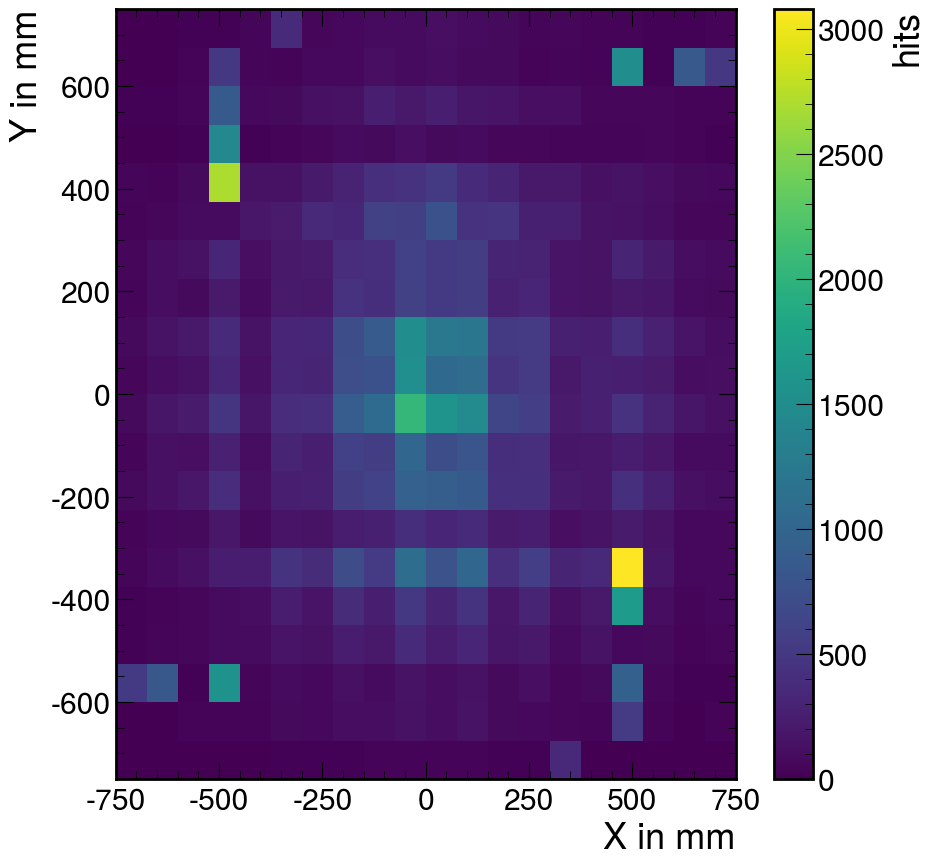

In [7]:
fig, ax = plt.subplots(1,1)

h, xedges, yedges, image = ax.hist2d(all_xs, all_ys,
                                       range=[[-750,750],[-750,750]],
                                       bins=20,
                                       cmap='viridis')
cbar = plt.colorbar(image, ax=ax)
cbar.set_label('hits')
ax.set_xlabel('X in mm')
ax.set_ylabel('Y in mm')



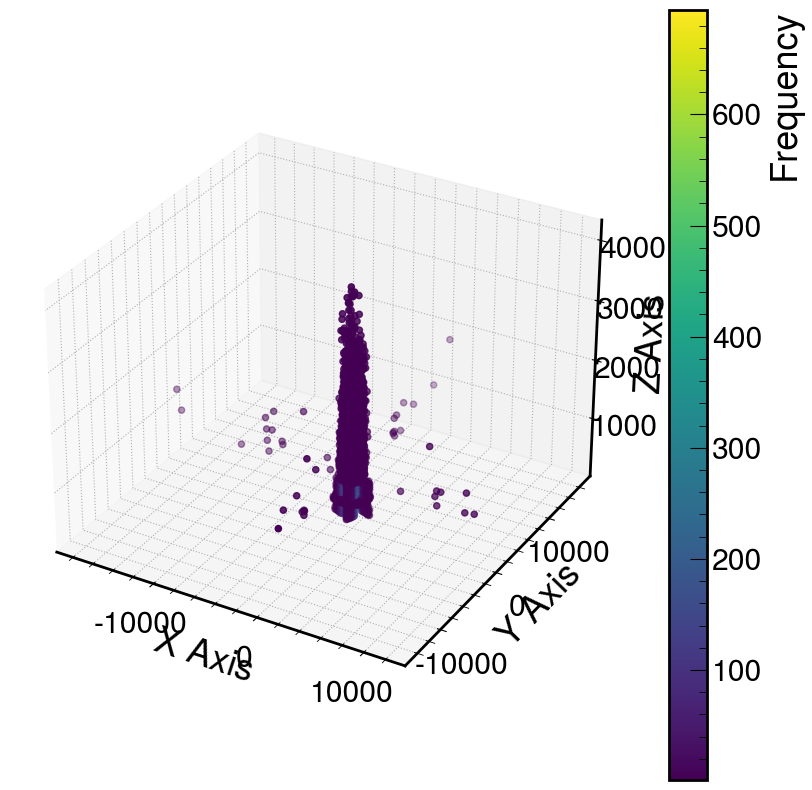

In [8]:
data = np.vstack([all_xs, all_ys, all_zs]).T

hist, edges = np.histogramdd(data, bins=300)

# Get the center of each bin
xedges, yedges, zedges = edges
xbins = 0.5 * (xedges[:-1] + xedges[1:])
ybins = 0.5 * (yedges[:-1] + yedges[1:])
zbins = 0.5 * (zedges[:-1] + zedges[1:])
# Create meshgrid
xgrid, ygrid, zgrid = np.meshgrid(xbins, ybins, zbins, indexing='ij')

# Flatten the arrays
xflat = xgrid.ravel()
yflat = ygrid.ravel()
zflat = zgrid.ravel()
freq = hist.ravel()

# Filter out zero frequencies for better visualization
nonzero = freq > 0
xflat = xflat[nonzero]
yflat = yflat[nonzero]
zflat = zflat[nonzero]
freq = freq[nonzero]

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xflat, yflat, zflat, c=freq, cmap='viridis')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Frequency')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.show()


In [9]:
import nbformat
print(nbformat.__version__)

5.10.4


In [10]:
fig = go.Figure(data=[go.Scatter3d(
    x=xflat,
    y=yflat,
    z=zflat,
    mode='markers',
    marker=dict(
        size=5,
        color=freq,
        colorscale='Viridis',
        colorbar=dict(title='Frequency')
    )
)])

fig.update_layout(
    title='background hits',
    scene=dict(
                xaxis=dict(title='X Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                yaxis=dict(title='Y Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                zaxis=dict(title='Z Axis (mm)', 
                           range=[0, 4000]
                           )
    )
)

fig.show()

## 3D visualization

In [122]:

for j, mass in enumerate(masses):

    for i, process in enumerate(processes):
   
        with uproot.open(f'ALP_m{mass}_{process}_ntuple_ecal.root') as f:
            events = f['Features'].arrays(library='np')

        all_xs = [hit for event in events['Xs'] for hit in event]
        all_ys = [hit for event in events['Ys'] for hit in event]
        all_zs = [hit for event in events['Zs'] for hit in event]
        
        photons_x = [hit for event in events['Xs'] for hit in event[:2]]
        photons_y = [hit for event in events['Ys'] for hit in event[:2]]
        photons_z = [hit for event in events['Zs'] for hit in event[:2]]

        data = np.vstack([all_xs, all_ys, all_zs]).T
        #data = np.vstack([photons_x, photons_y, photons_z]).T

        # Calculate the 3D histogram
        hist, edges = np.histogramdd(data, bins=100)

        # Get the center of each bin
        xedges, yedges, zedges = edges
        xbins = 0.5 * (xedges[:-1] + xedges[1:])
        ybins = 0.5 * (yedges[:-1] + yedges[1:])
        zbins = 0.5 * (zedges[:-1] + zedges[1:])

        # Create meshgrid
        xgrid, ygrid, zgrid = np.meshgrid(xbins, ybins, zbins, indexing='ij')

# Flatten the arrays
        xflat = xgrid.ravel()
        yflat = ygrid.ravel()
        zflat = zgrid.ravel()
        freq = hist.ravel()

        # Filter out zero frequencies for better visualization
        nonzero = freq > 0
        xflat = xflat[nonzero]
        yflat = yflat[nonzero]
        zflat = zflat[nonzero]
        freq = freq[nonzero]

        # Plot the interactive 3D scatter plot
        fig = go.Figure(data=[go.Scatter3d(
            x=xflat,
            y=yflat,
            z=zflat,
            mode='markers',
            marker=dict(
                size=5,
                color=freq,
                colorscale='Viridis',
                colorbar=dict(title='Frequency')
            )
        )])

        fig.update_layout(
            title=f'All Photon hits for m{mass}_{process}',
            scene=dict(
                xaxis=dict(title='X Axis (mm)', 
                           range=[-500, 500]
                           ),
                yaxis=dict(title='Y Axis (mm)', 
                           range=[-500, 500]
                           ),
                zaxis=dict(title='Z Axis (mm)', 
                           range=[0, 500]
                           )
            )
        )

        fig.show()

## Playing around


13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309
13309


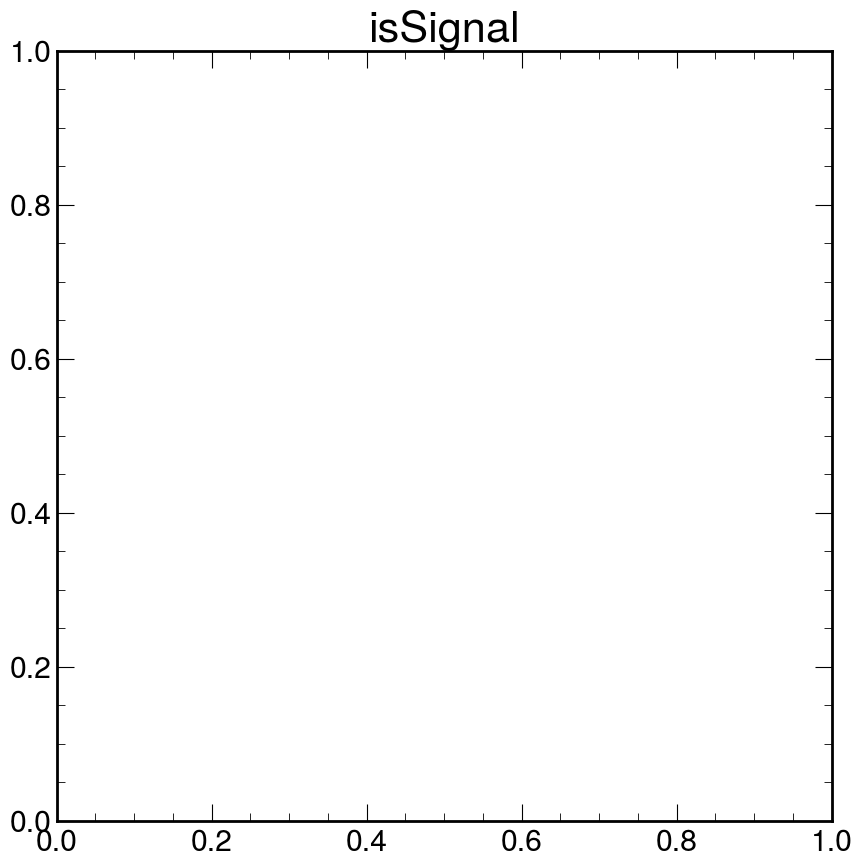

In [75]:
for feature in features:

    #fig, ax = plt.subplots(1, 1)
    #n, bins, patches = ax.hist(df[feature])
    ax.set_yscale('log')
    plt.title(feature)
    print(len(df[feature]))
    



NameError: name 'pz' is not defined

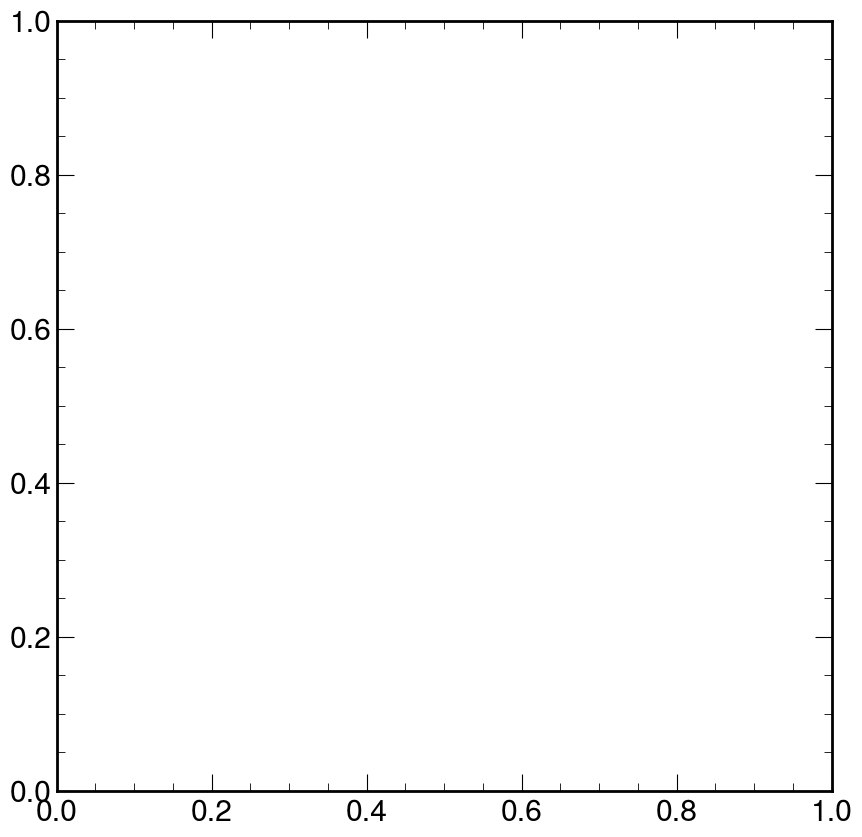

In [76]:
fig, ax = plt.subplots(1,1)
h, xedges, yedges, image = ax.hist2d(pz, zangle, bins=100, range=[[0,8],[0,0.5*math.pi]], cmap=plt.cm.viridis)
cbar = plt.colorbar(image, ax=ax)

## Histograms with BKGD

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:

invalid value encountered in divide

/var/folders/c1/t_82_v851pj2jb4v53l201640000gn/T/ipykernel_38755/1830519230.py:37: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



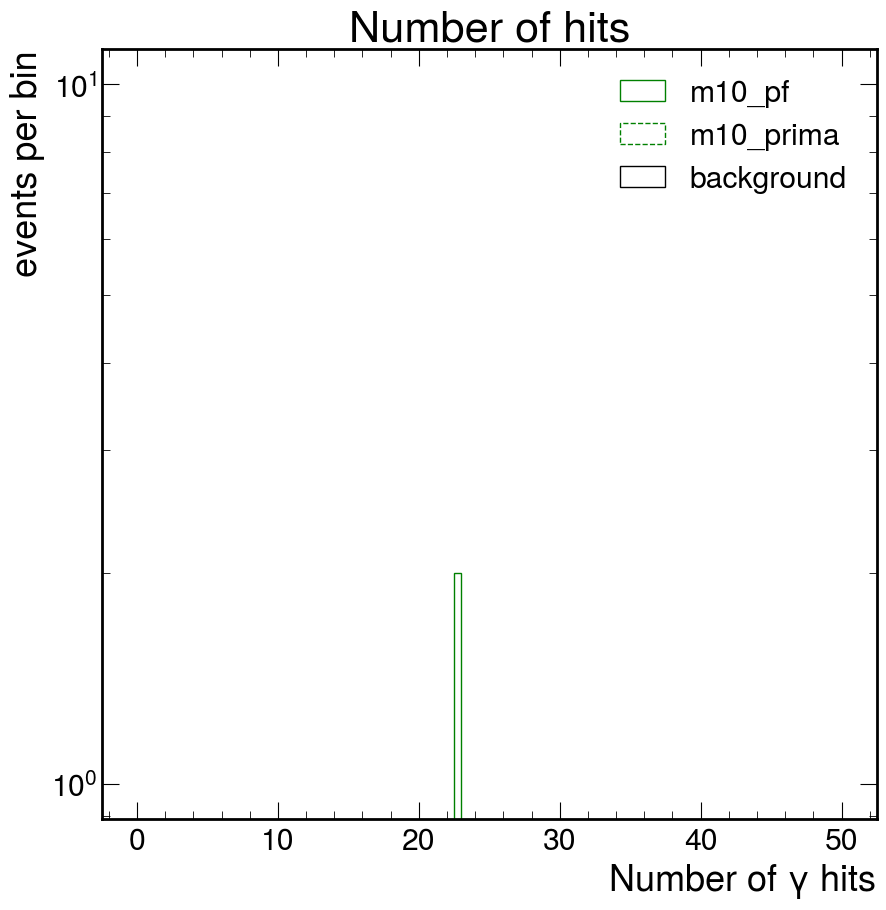

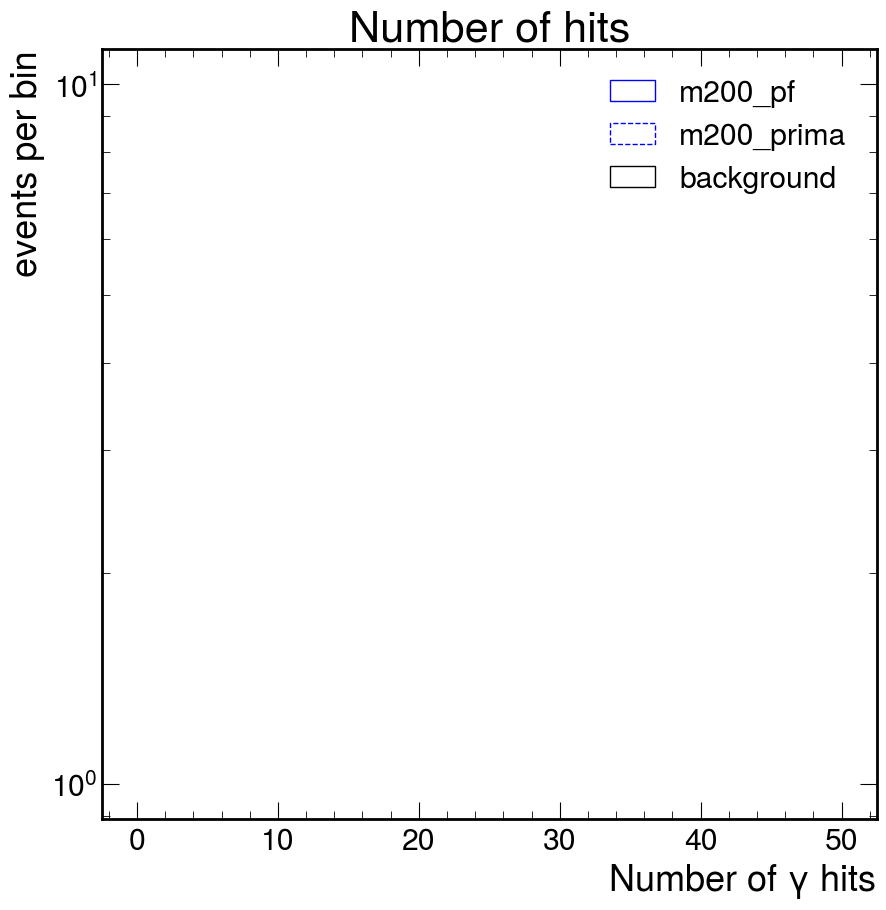

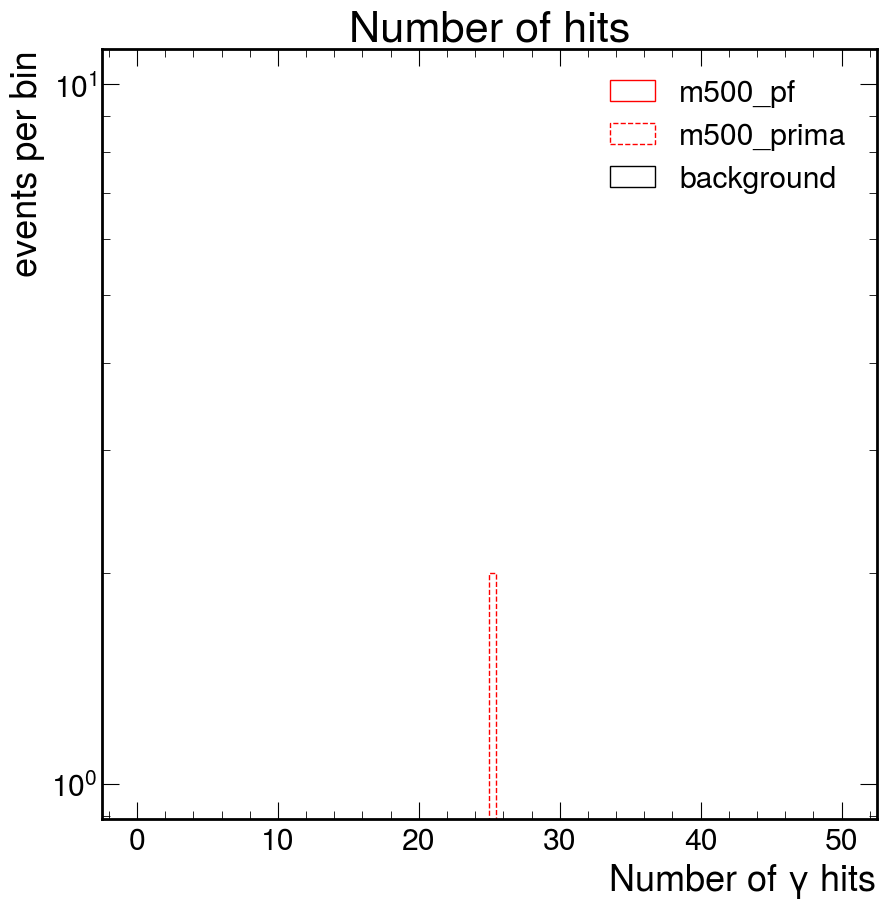

In [474]:
with uproot.open(f'ALP_mall_PN_ntuple.root') as f:
    bkgd = f['Features'].arrays()

processes = ['pf','prima']
masses = [10, 200, 500]
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]

for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)

    for i, process in enumerate(processes):
   
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("Number of hits")
        n, bins, patches = ax.hist(events['XYAv'],
                                   histtype = 'step',
                                   bins=100,
                                   range=(0,50),
                                   density=True,
                                   linestyle = styles[i],
                                   color = colors[j],
                                   alpha=1,
                                   label=f'm{mass}_{process}')
    n, bins, patches = ax.hist(bkgd['XYAv'],
                                histtype = 'step',
                                bins=100,
                                range=(0,50),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=1,
                                label=f'background')

    plt.legend()
    ax.set_yscale('log')
    ax.set_ylabel('events per bin')
    ax.set_xlabel('Number of $\gamma$ hits')          

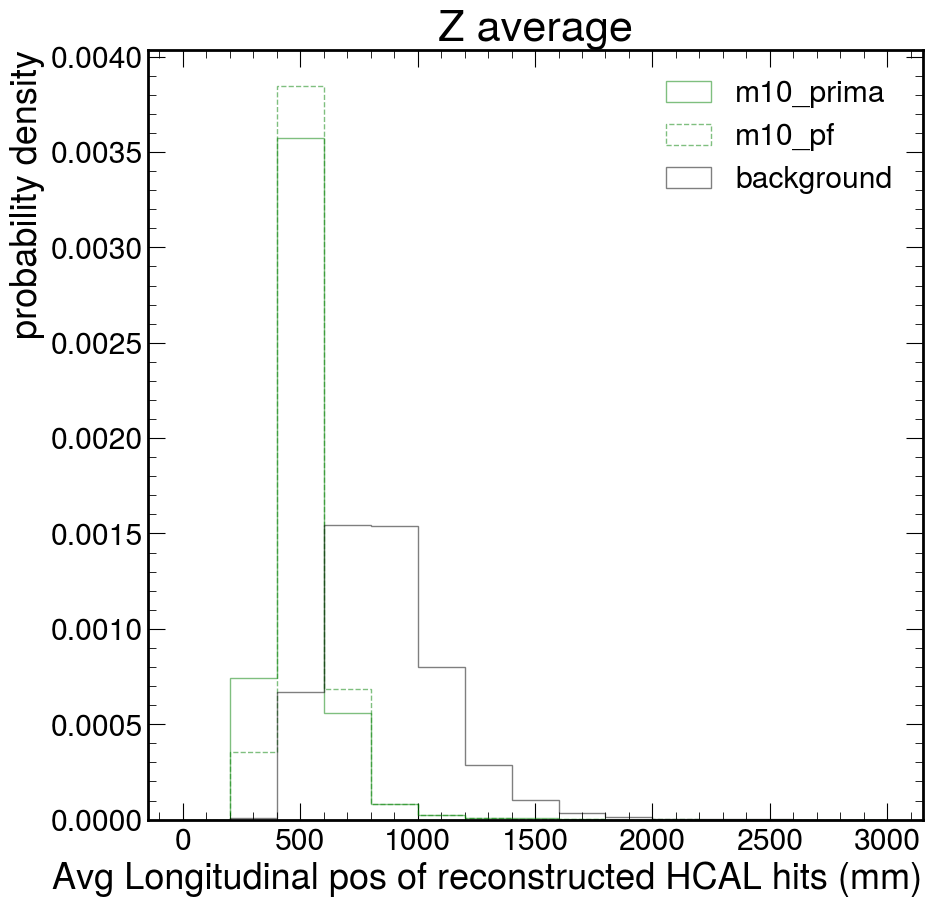

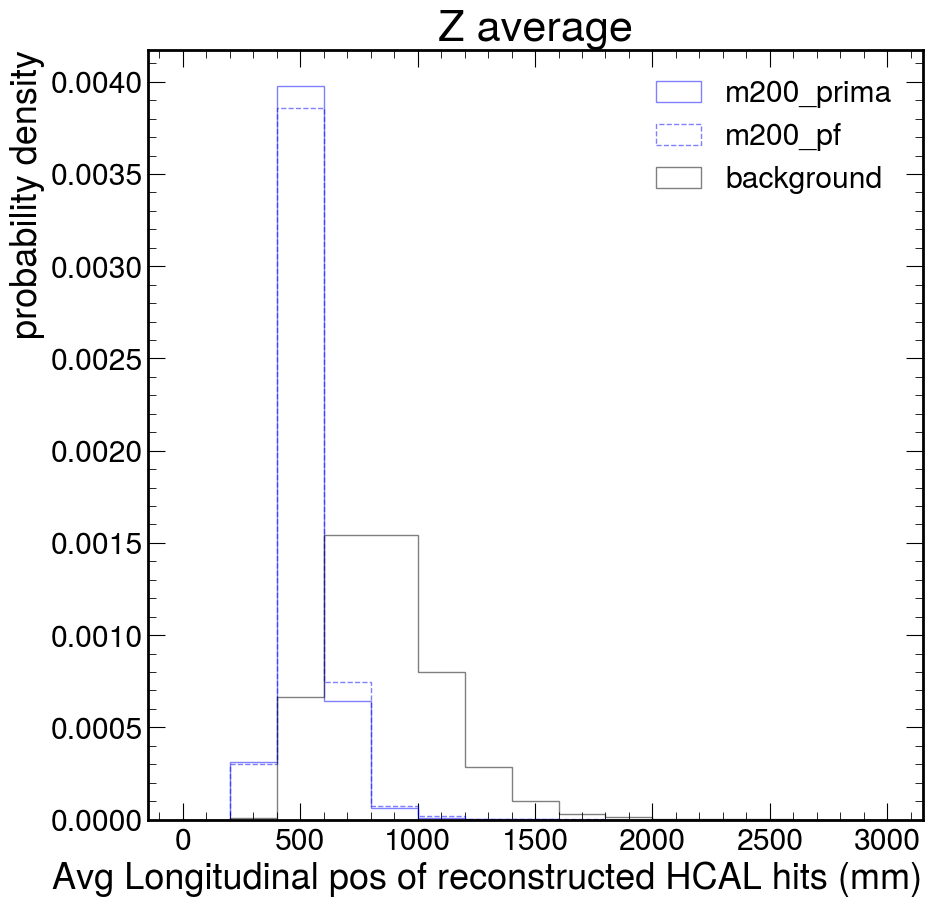

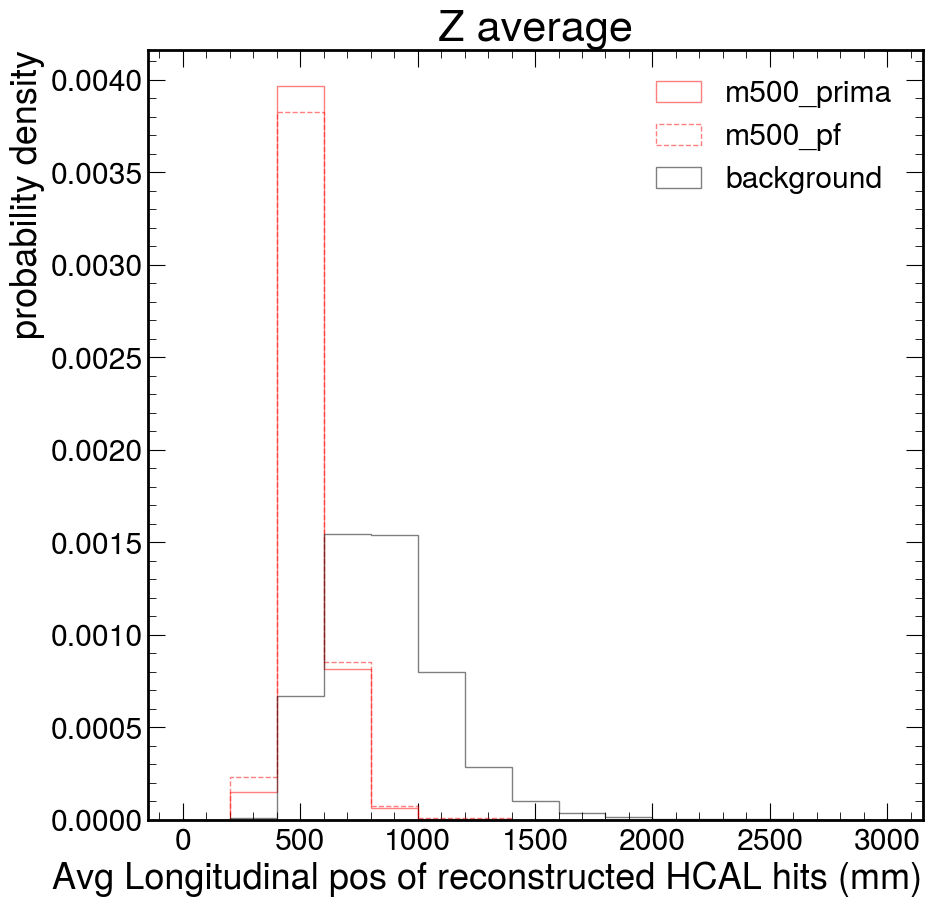

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]

    

for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("Z average")
        n, bins, patches = ax.hist(events['ZAv'],
                                   histtype = 'step',
                                   density=True,
                                   bins=15,
                                   linestyle = styles[i],
                                   color = colors[j],
                                   alpha=0.5,
                                   range=(0,3000),
                                   label=f'm{mass}_{process}')
    n, bins, patches = ax.hist(bkgd['ZAv'],
                                histtype = 'step',
                                bins=15,
                                range=(0,3000),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label=f'background')
    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Avg Longitudinal pos of reconstructed HCAL hits (mm)')

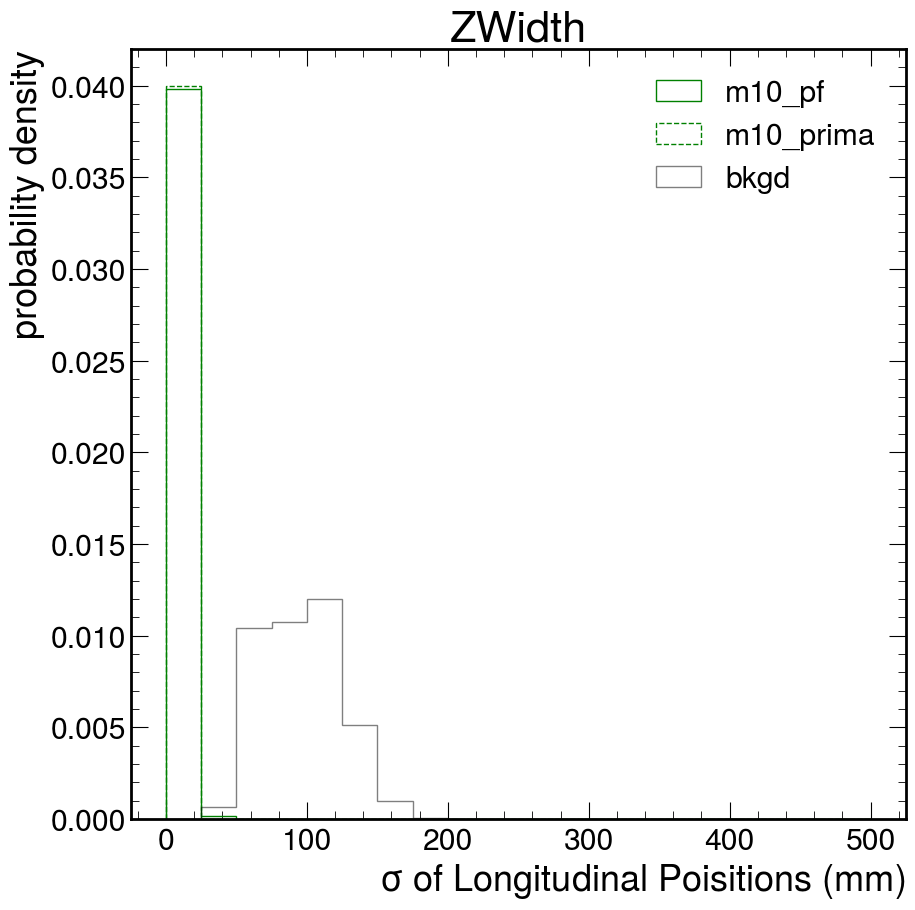

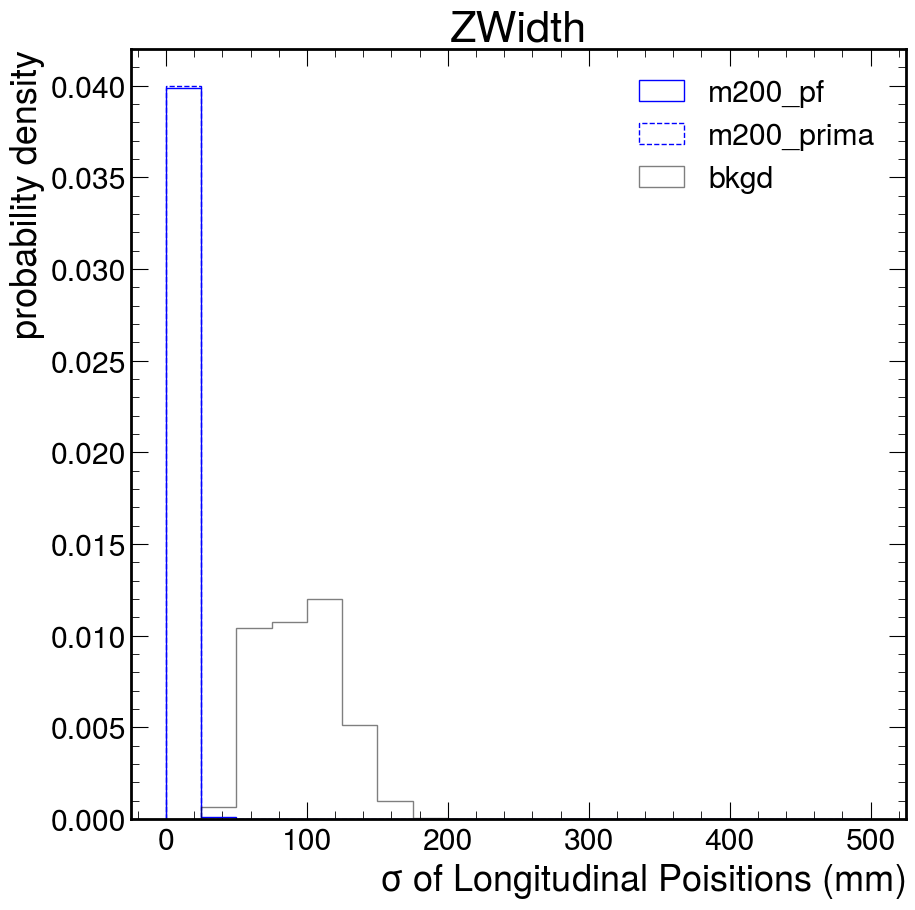

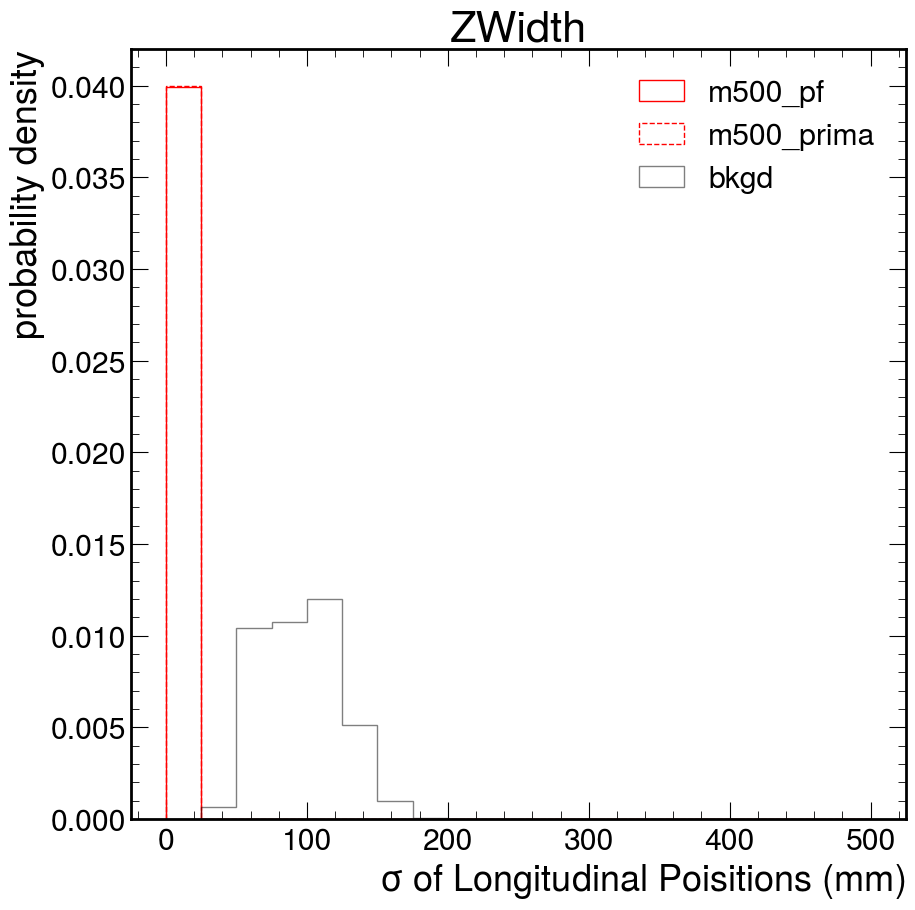

In [189]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("ZWidth")
        n, bins, patches = ax.hist(events['e_ZWidth'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,500),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
    n, bins, patches = ax.hist(bkgd['e_ZWidth'],
                                histtype = 'step',
                                bins=20,
                                range=(0,500),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label=f'bkgd')
    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel("$\sigma$ of Longitudinal Poisitions (mm)")

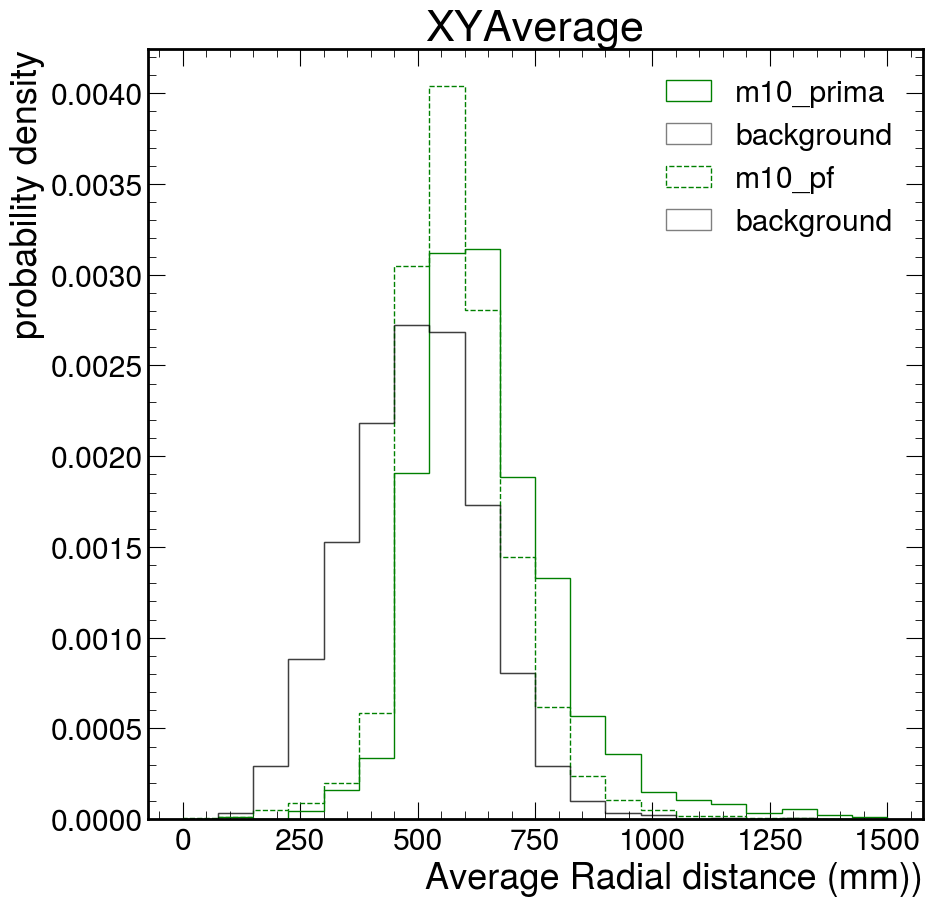

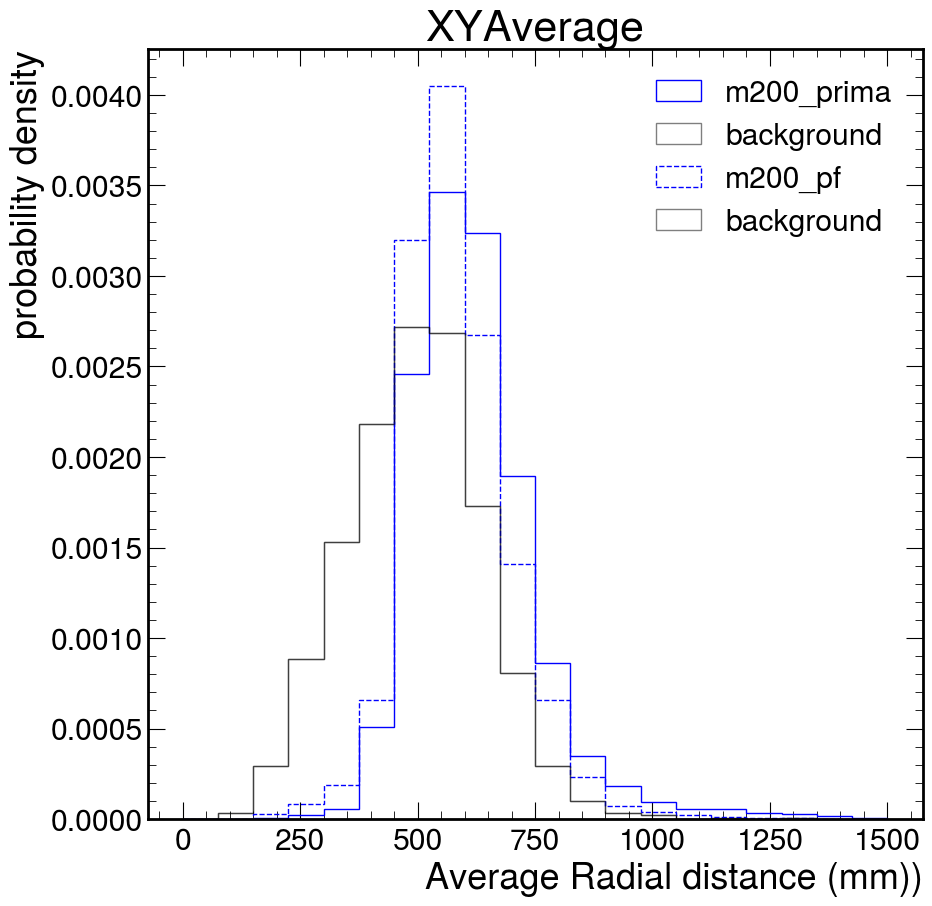

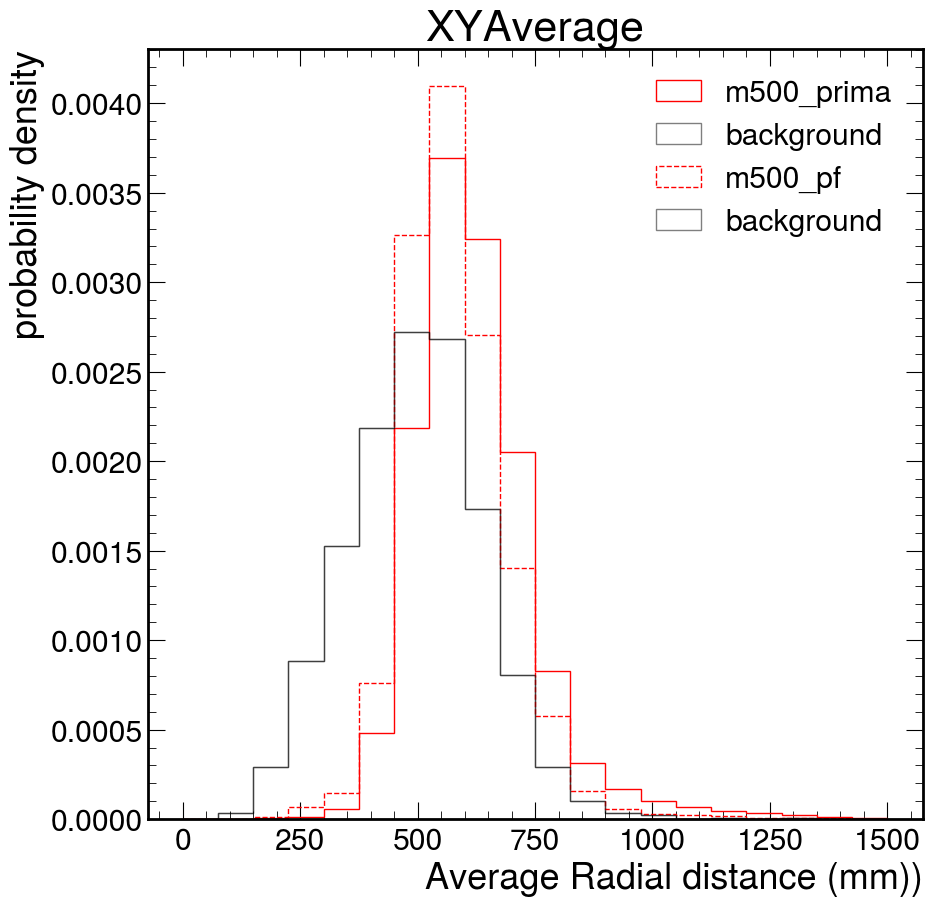

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("XYAverage")
        n, bins, patches = ax.hist(events['XYAv'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                range=(0,1500),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['XYAv'],
                                    histtype = 'step',
                                    bins=20,
                                   range=(0,1500),
                                       density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Radial distance (mm))')

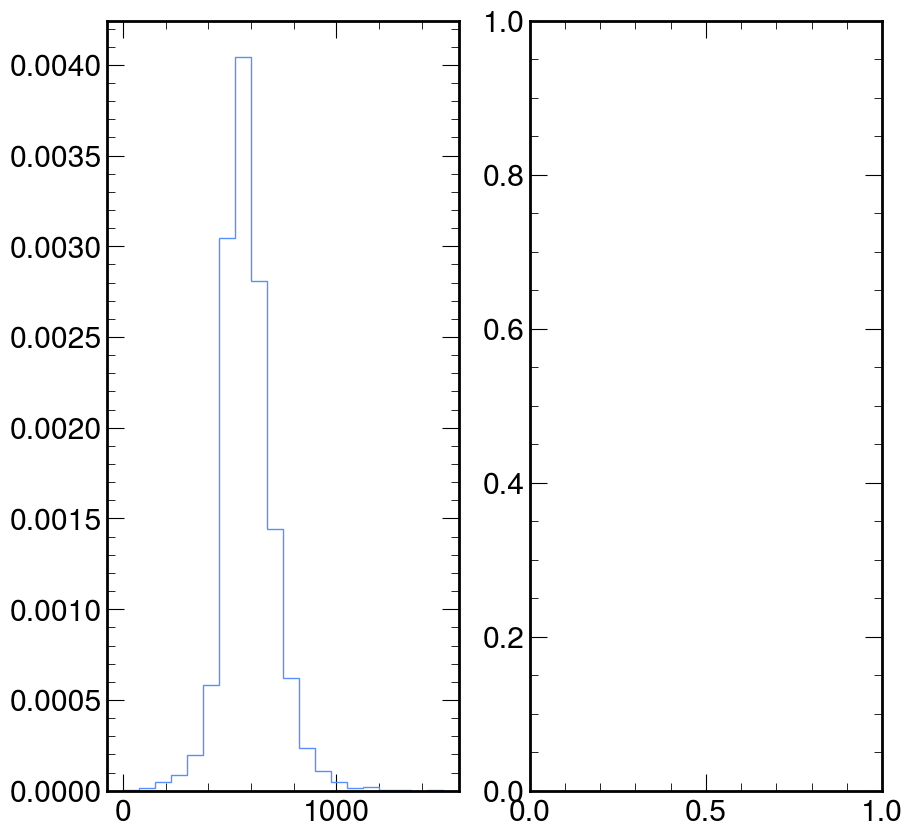

In [ ]:
with uproot.open(f'ALP_m10_pf_ntuple.root') as f:
    events = f['Features'].arrays()

fig, ax = plt.subplots(1, 2)
n, bins, patches = ax[0].hist(events['XYAv'],
                              histtype = 'step',
                              density=True,
                              bins=20,
                              range=(0,1500))
                              

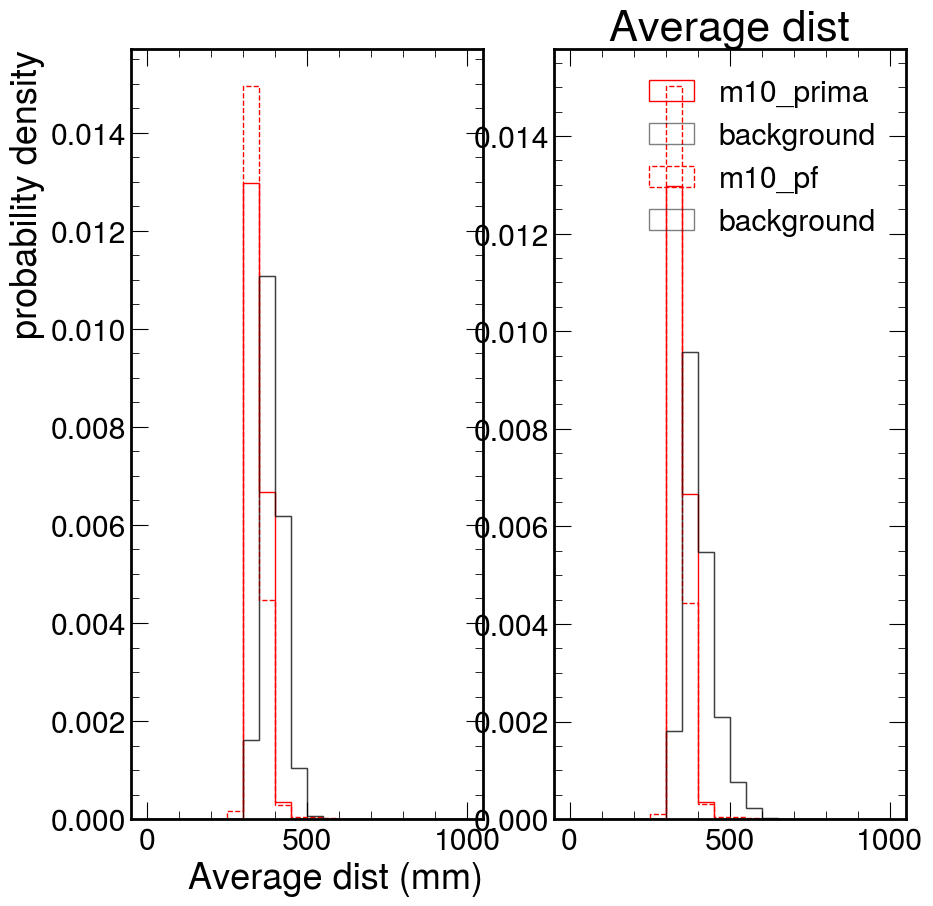

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
#for j, mass in enumerate(masses):
fig, ax = plt.subplots(1, 2)
for i, process in enumerate(processes):

    with uproot.open(f'ALP_m500_{process}_ntuple_ecal.root') as f:
        events = f['Features'].arrays()
    plt.title("Average dist")
    n, bins, patches = ax[0].hist(events['ZAv'],
                                histtype = 'step',
                                density=True,
                                bins=20,
                                range=(0,1000),
                                linestyle = styles[i],
                                color = colors[j],
                                label=f'm10_{process}')
    n, bins, patches = ax[0].hist(bkgd['ZAv'],
                                histtype = 'step',
                                bins=20,
                                range=(0,1000),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label='background')
    n, bins, patches = ax[1].hist(events['ZAverage_w'],
                                histtype = 'step',
                                density=True,
                                bins=20,
                                range=(0,1000),
                                linestyle = styles[i],
                                color = colors[j],
                                label=f'm10_{process}')
    n, bins, patches = ax[1].hist(bkgd['ZAverage_w'],
                                histtype = 'step',
                                bins=20,
                                range=(0,1000),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax[0].set_ylabel('probability density')
    ax[0].set_xlabel('Average dist (mm)')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:

invalid value encountered in divide

/var/folders/c1/t_82_v851pj2jb4v53l201640000gn/T/ipykernel_38755/2065211792.py:31: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



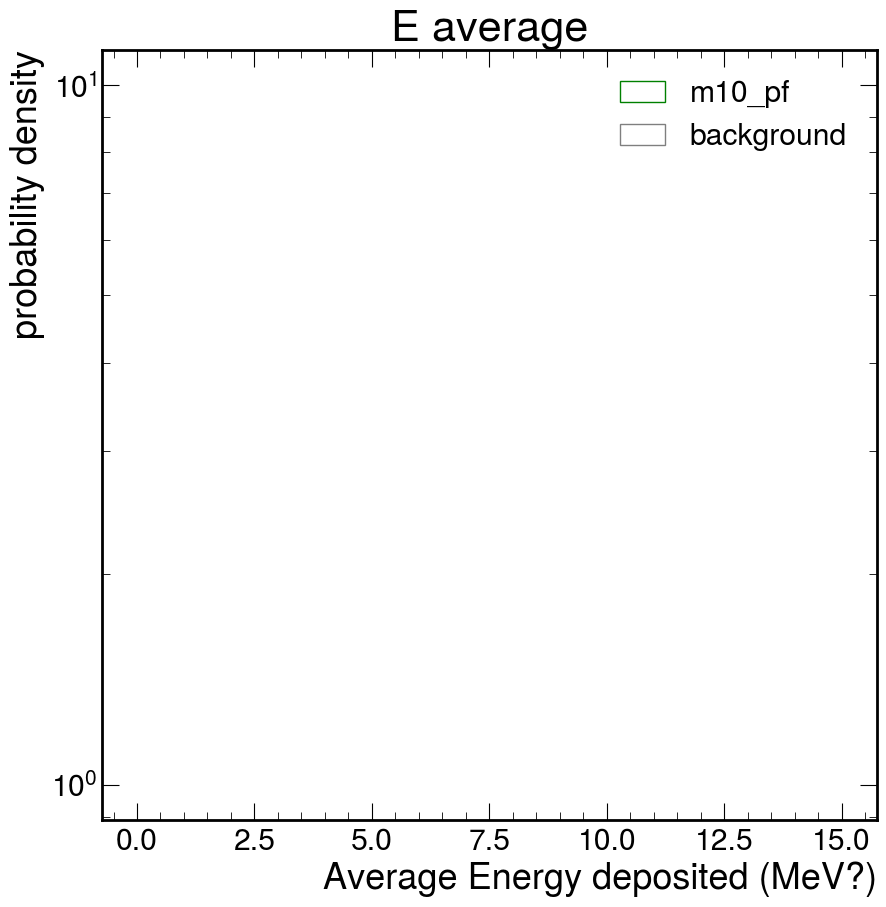

In [133]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
processes = ['pf']
masses = [10]
for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m10_{process}_ntuple_ecal.root') as f:
            events = f['Features'].arrays()
        plt.title("E average")
        n, bins, patches = ax.hist(events['Eav'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,15),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['Eav'],
                                    histtype = 'step',
                                    bins=20,
                                    range=(0,15),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Energy deposited (MeV?)')

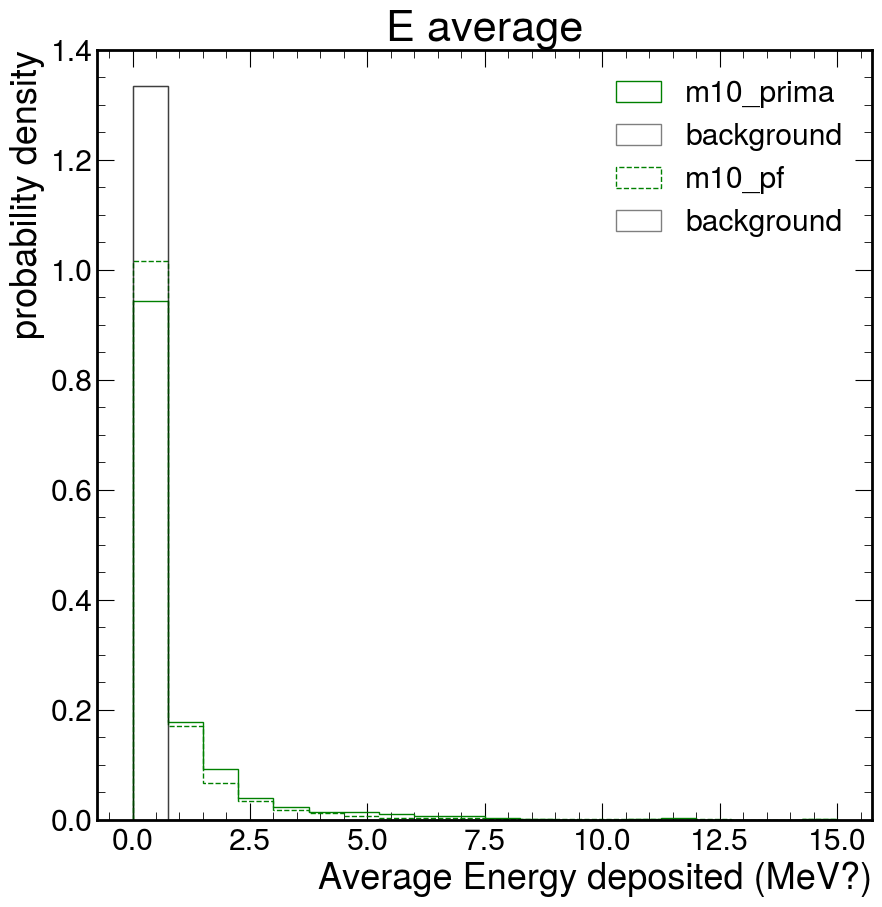

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate([10]):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m10_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("E average")
        n, bins, patches = ax.hist(events['Eav_cut_2'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,15),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['Eav_cut_3'],
                                    histtype = 'step',
                                    bins=20,
                                    range=(0,15),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Energy deposited (MeV?)')

## Observations from generator plots

* Photons scatter more from ALP in Primakoff process than photon fusion
* More extreme behavior at 10 MeV / c^2 but spread is proportional to mass of ALP
* In primakoff, photons have less z momentum (makes sense because scatter more)

## Observations from reconstructed histograms

* Regarding number of hits
    * It is more likely for photon fusion to get a hit than primakoff at 200 and 500 MeV
    * However, primakoff has a higher chance of recording a larger number of hits
    * This is opposite at 10 MeV

* Average z of hits
    * More likely for photon fusion photons to get farther
    * At 10 this is the opposite, as the mode for primakoff is farther than mode of photon fusion
    * Photon fusion has more standard deviation

*  E deposited
    * for 200 and 500 MeV, higher energy deposits more likely with primakoff, until >8 GeV, when photon fusion more likely, which is very rare
    * Primakoff yields more low energy deposits at 10 and 200, but photon fusion for 500



## Figuring out where to cut

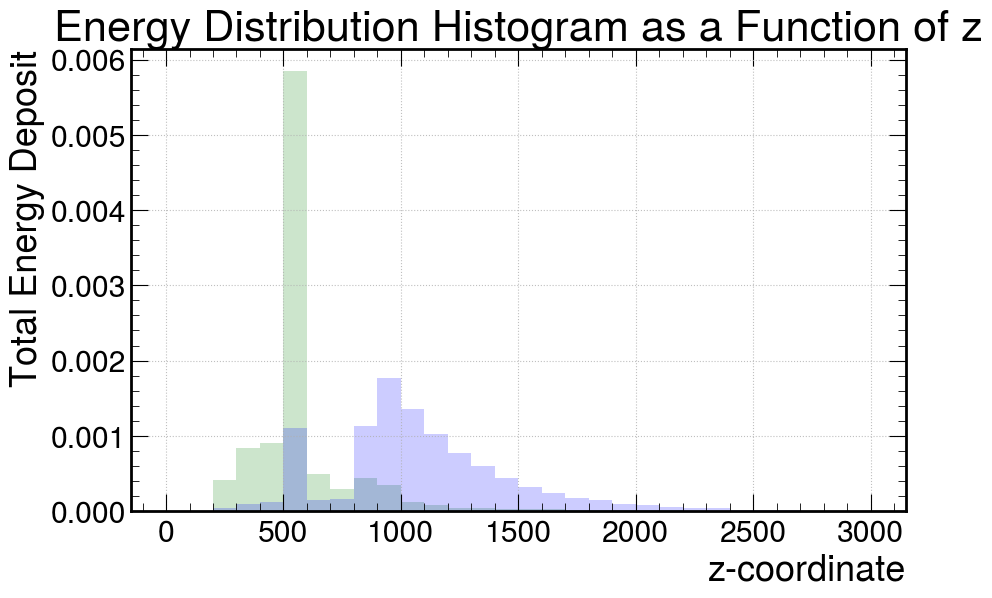

In [ ]:
## need to figure out where most of the energy is deposited, 
with uproot.open(f'ALP_mall_PN_ntuple.root') as f:
    bkgd = f['Features'].arrays()

bkgd_es = [hit for event in bkgd['Es'] for hit in event]
bkgd_zs = [hit for event in bkgd['Zs'] for hit in event]

with uproot.open('ALP_m500_pf_ntuple.root') as f:
    tree = f['Features']
    df = tree.arrays(library='np')
    features = tree.keys()

all_zs = [hit for event in df['Zs'] for hit in event]
all_es = [hit for event in df['Es'] for hit in event]


plt.figure(figsize=(10, 6))
plt.hist(all_zs, bins=30, weights=all_es, color='green', alpha=0.2, range=(0,3000), density=True)
plt.hist(bkgd_zs, bins=30, weights=bkgd_es, color='blue', alpha=0.2, range=(0,3000), density=True)
plt.xlabel('z-coordinate')
plt.ylabel('Total Energy Deposit')
plt.title('Energy Distribution Histogram as a Function of z')
plt.grid(True)
plt.show()

## Exploring data for BDT

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import datasets
from sklearn import svm

In [ ]:
with uproot.open("ALP_m200_prima_ntuple.root") as f:
    signal = f['Features'].arrays(library='pd')

with uproot.open("ALP_mall_PN_ntuple.root") as f:
    bkgd = f['Features'].arrays(library='pd')

#assigning labels
signal['Label'] = 'signal'
bkgd['Label'] = 'bkgd'

signal['Label'] = signal.Label.astype('category')
bkgd['Label'] = bkgd.Label.astype('category')


ex = pd.read_csv('training_10k.csv')

data = pd.concat([bkgd, signal], ignore_index=True)

data['Label'] = pd.Categorical(data['Label'])

col = np.r_[1:5, 9: ]
features = data.columns[:-2]
features = features.drop(['Xs', 'Ys', 'Zs', 'Es'])
data

FileNotFoundError: [Errno 2] No such file or directory: 'training_10k.csv'

In [ ]:
#splitting in testing and training
features = data.columns[:-2]

X = data[features]
y = data['Label']

skf = StratifiedKFold(n_splits=3)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")
    
    # Splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Check the distribution of labels in each set
    print("Train label distribution:\n", y_train.value_counts())
    print("Test label distribution:\n", y_test.value_counts())
    print("-" * 40)

# ratios are preserved

Fold 1
Train label distribution:
 Label
bkgd      2465
signal    1611
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1233
signal     805
Name: count, dtype: int64
----------------------------------------
Fold 2
Train label distribution:
 Label
bkgd      2465
signal    1611
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1233
signal     805
Name: count, dtype: int64
----------------------------------------
Fold 3
Train label distribution:
 Label
bkgd      2466
signal    1610
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1232
signal     806
Name: count, dtype: int64
----------------------------------------


In [136]:
with uproot.open("ALP_m200_prima_ntuple.root") as f:
    signal = f['Features'].arrays(library='pd')

with uproot.open("ALP_mall_PN_ntuple.root") as f:
    bkgd = f['Features'].arrays(library='pd')

signal


,NHits,ZLength,ZAverage_w,XAverage,YAverage,Ys,Xs,Zs,Es,ZWidth_w,...,e_ZWidth_w,e_ZAv,e_ZWidth,e_XYAv,e_XYAv_w,e_XYWidth,e_XYWidth_w,e_DeltaZ,e_Eav,e_EDensity
0,3.0,250.0,617.272705,0.0,0.0,"[-358.95001220703125, 194.0500030517578, -580....","[462.34075927734375, -562.3407592773438, -606....","[665.0, 540.0, 415.0]","[0.674329400062561, 0.11512941122055054, 0.115...",87.551636,...,0.0,0.0,0.0,0.0,0.0,0.0,34.727688,0.0,0.0,0.0
1,2.0,175.0,502.254913,0.0,0.0,"[353.04998779296875, 397.04998779296875]","[-134.6592559814453, -462.34075927734375]","[540.0, 365.0]","[0.6578823328018188, 0.1809176504611969]",71.977081,...,0.0,0.0,0.0,0.0,0.0,0.0,34.727688,0.0,0.0,0.0
2,7.0,513.0,557.733276,0.0,0.0,"[-361.382568359375, -314.95001220703125, -314....","[375.0, -215.3407440185547, -165.3407440185547...","[928.0, 540.0, 540.0, 540.0, 540.0, 415.0, 665.0]","[0.19093240797519684, 0.06578823179006577, 0.1...",99.763657,...,0.0,0.0,0.0,0.0,0.0,0.0,19.263456,0.0,0.0,0.0
3,3.0,275.0,303.150299,0.0,0.0,"[-5.949999809265137, -580.9500122070312, -155....","[474.34075927734375, -606.3407592773438, -650....","[540.0, 265.0, 540.0]","[0.4934117794036865, 4.901223659515381, 0.2960...",95.057274,...,0.0,0.0,0.0,0.0,0.0,0.0,19.263456,0.0,0.0,0.0
4,6.0,225.0,344.901947,0.0,0.0,"[194.0500030517578, -480.95001220703125, -255....","[474.34075927734375, -870.3407592773438, -914....","[540.0, 315.0, 540.0, 365.0, 415.0, 465.0]","[0.1809176504611969, 8.536023139953613, 0.9045...",73.114021,...,0.0,0.0,0.0,0.0,0.0,0.0,19.263456,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12513,5.0,200.0,537.877380,0.0,0.0,"[353.04998779296875, 353.04998779296875, 397.0...","[15.340749740600586, -34.65924835205078, -462....","[540.0, 540.0, 415.0, 615.0, 540.0]","[1.1348470449447632, 0.26315292716026306, 0.09...",35.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,345.930054,0.0,0.0,0.0
12514,6.0,225.0,465.471710,0.0,0.0,"[353.04998779296875, 353.04998779296875, 397.0...","[115.34075164794922, 65.34075164794922, -462.3...","[540.0, 540.0, 315.0, 365.0, 540.0, 540.0]","[0.6085411906242371, 0.08223529160022736, 0.06...",87.076546,...,0.0,0.0,0.0,0.0,0.0,0.0,345.930054,0.0,0.0,0.0
12515,3.0,275.0,273.240753,0.0,0.0,"[-358.95001220703125, -402.95001220703125, -44...","[462.34075927734375, 284.65924072265625, 462.3...","[265.0, 540.0, 315.0]","[4.226893901824951, 0.11512941122055054, 0.098...",44.139484,...,0.0,0.0,0.0,0.0,0.0,0.0,25.483158,0.0,0.0,0.0
12516,7.0,225.0,393.700012,0.0,0.0,"[-205.9499969482422, -55.95000076293945, 619.0...","[474.34075927734375, 474.34075927734375, 518.3...","[540.0, 540.0, 315.0, 515.0, 365.0, 415.0, 515.0]","[0.27959999442100525, 0.11512941122055054, 0.1...",55.238663,...,0.0,0.0,0.0,0.0,0.0,0.0,25.483158,0.0,0.0,0.0


In [ ]:
np.random.rand(1)

array([0.82713015])

In [390]:
position = -1
count = 0
successes = 0
chances = 0
max_steps = 1000000
for i in range(1000):
    position = -1
    chances += 1
    for i in range(max_steps):
        random = np.random.rand()
        if random <= (0.33333):
            position += 1
        else:
            position -= 1

        count += 1
        if position == 0:
            successes += 1
            break
    

print(successes)
print(count)
successes / chances


502
498001610


0.502

## Post BDT Cut analysis


In [464]:
#dictionary to store cuts
processes = ['prima', 'pf']
cuts = {'Processes': processes}
cuts[10] = [0.91, 0.95]
cuts[100] = [0.92, 0.95]
cuts[150] = [0.92, 0.94]
cuts[200] = [0.92, 0.94]
cuts[300] = [0.86, 0.94]
cuts[400] = [0.82, 0.90]
cuts[500] = [0.77, 0.90]




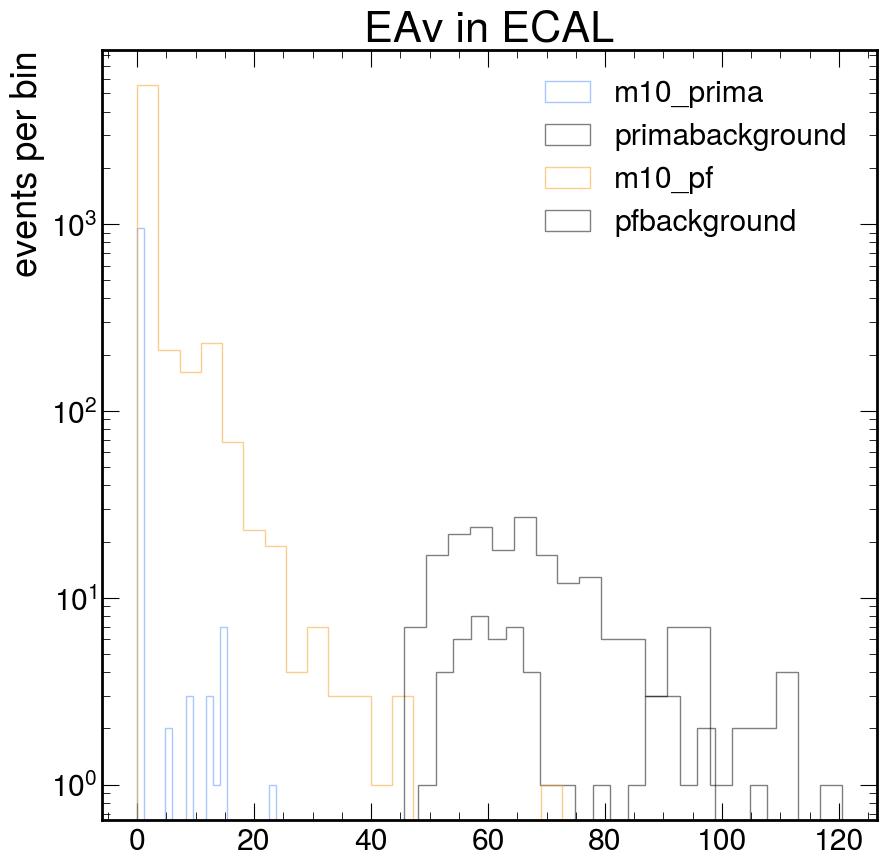

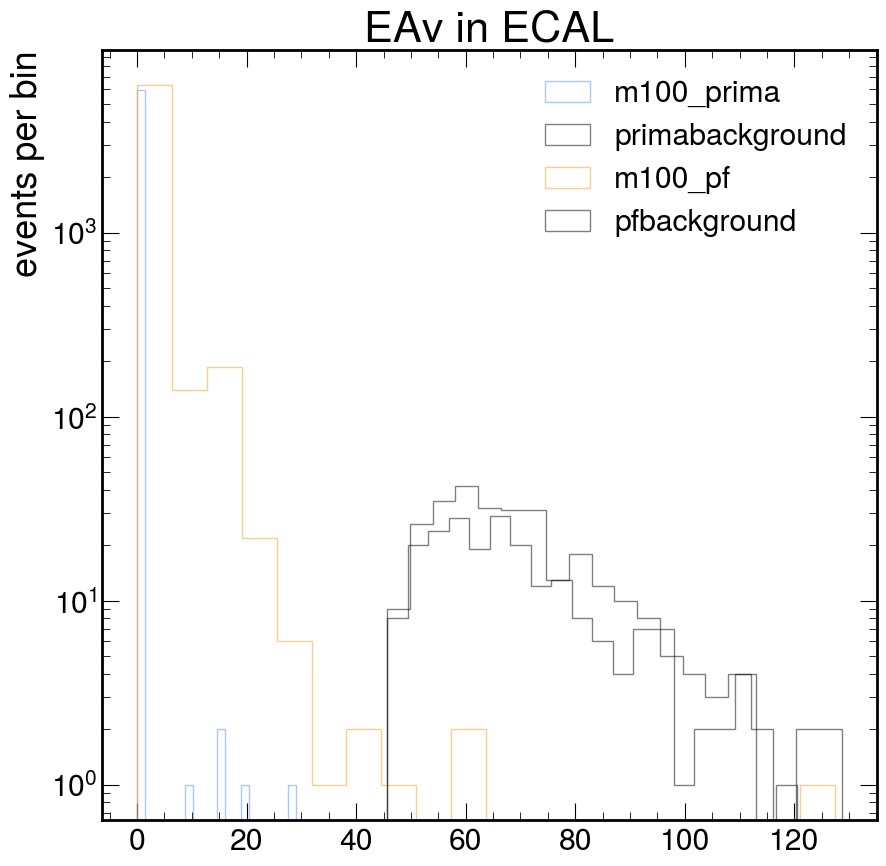

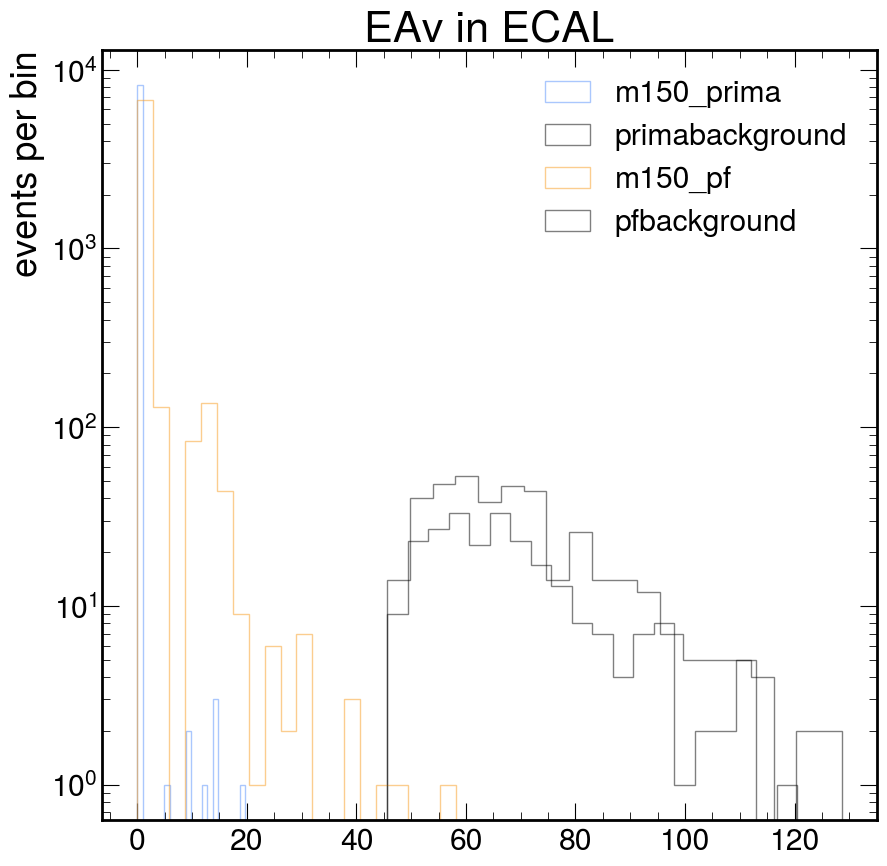

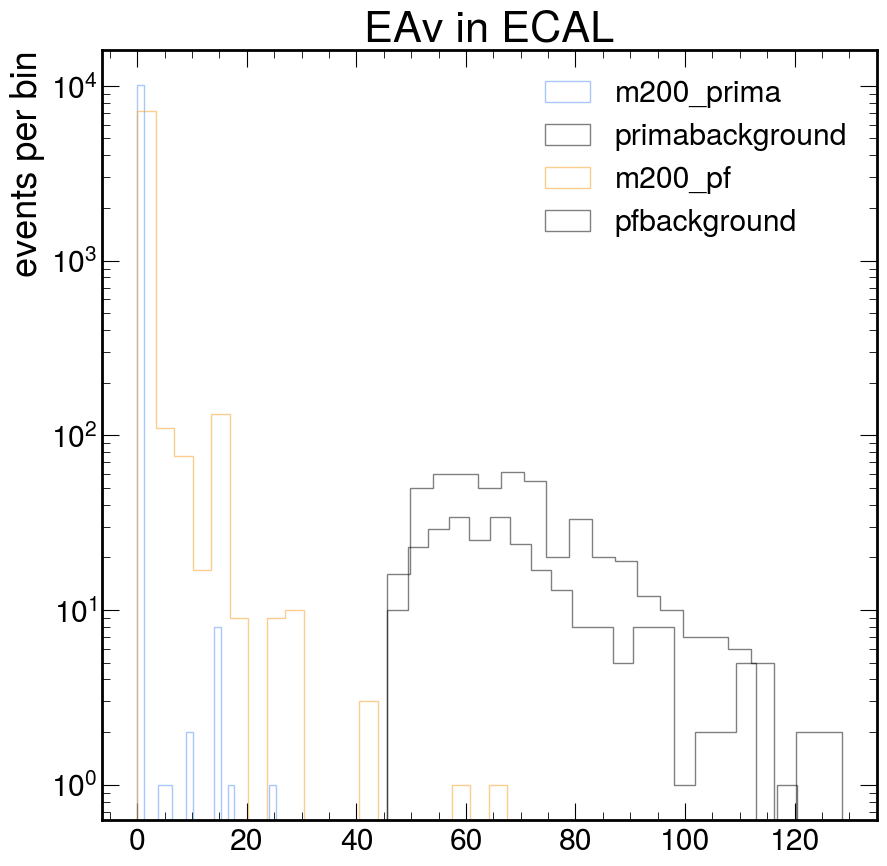

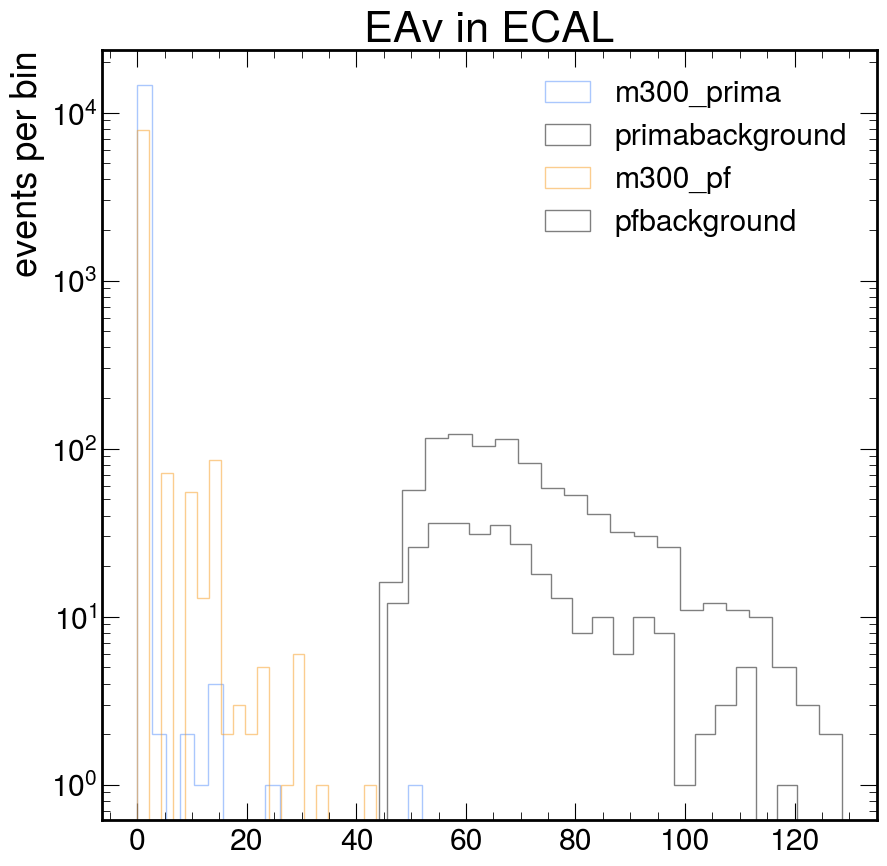

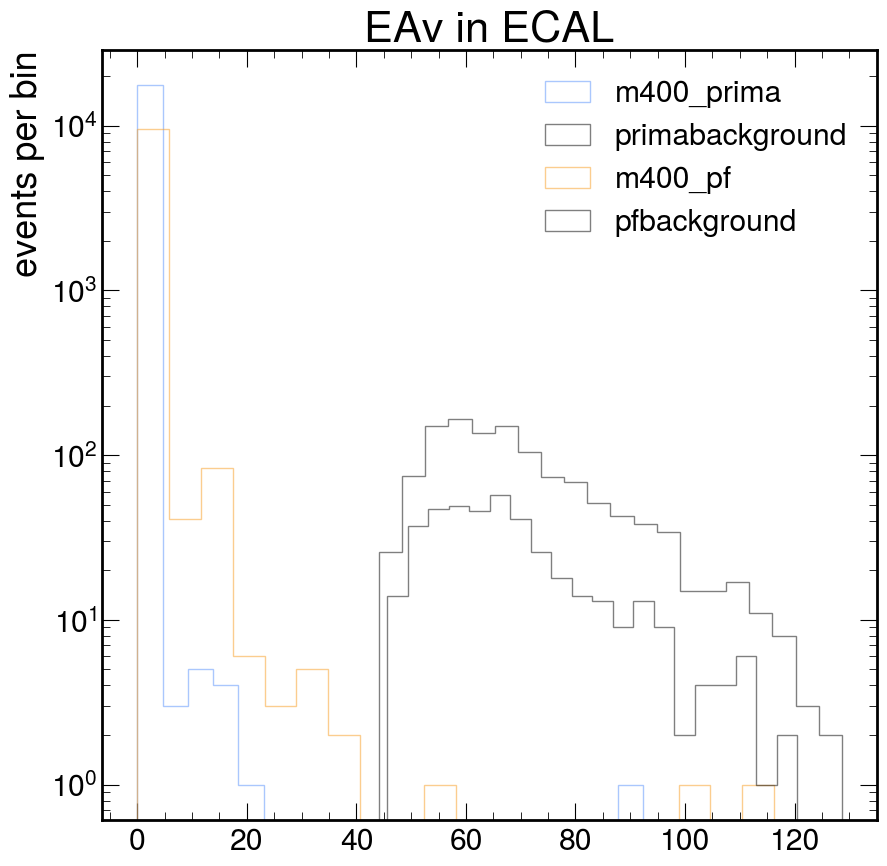

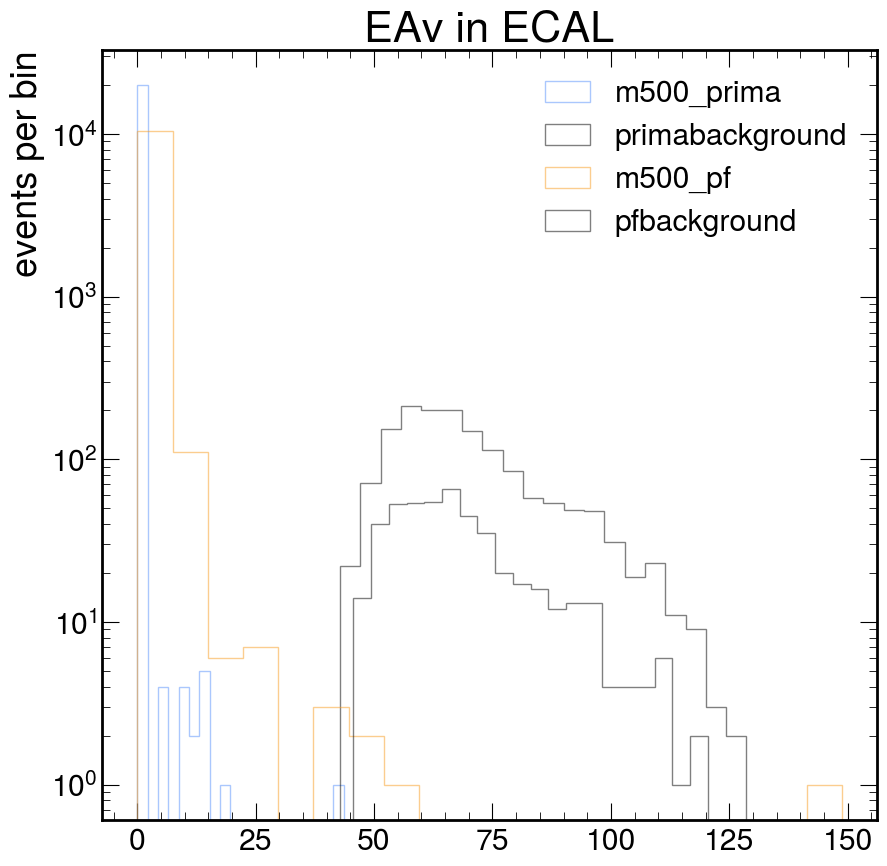

In [469]:
with uproot.open(f'ALP_m200_pf_scored_ntuple.root') as f:
    events = f['Features'].arrays(library='pd')


feature = 'e_ZWidth'

processes = ['prima', 'pf']
masses = [10, 100, 150, 200, 300, 400, 500]
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]

cut_eff = {'Processes': processes}
for mass in masses:
    cut_eff[mass] = []

b_cut_eff = {'Processes': processes}
for mass in masses:
    b_cut_eff[mass] = []


h_fracs= []
b_fracs = []

for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)

    for i, process in enumerate(processes):
   
        with uproot.open(f'ALP_m{mass}_{process}_scored_ntuple.root') as f:
            events = f['Features'].arrays()
        
        score = cuts[mass][i]
        passed = events[events['BdtScore'] >= score]
        passed_sig = passed[passed['Label'] == 1.0]
        passed_bkgd = passed[passed['Label'] == 0.0]
        rejected = events[events['BdtScore'] < score]
        rejected_sig = rejected[rejected['Label'] == 1.0]
        rejected_bkgd = rejected[rejected['Label'] == 0.0]  

        h_sig_e = passed_sig['NHits'] * passed_sig['Eav']
        h_bkgd_e = passed_bkgd['NHits'] * passed_bkgd['Eav']
        e_sig_e = passed_sig['e_NHits'] * passed_sig['e_Eav']
        e_bkgd_e = passed_bkgd['e_NHits'] * passed_bkgd['e_Eav']
        total_sig_e = np.add(h_sig_e, e_sig_e)
        total_bkgd_e = np.add(h_bkgd_e, e_bkgd_e)
        h_frac = h_sig_e / total_sig_e
        b_frac = h_bkgd_e / total_bkgd_e

        cut = h_frac[h_frac >= 0.6]
        cut_eff[mass].append(len(cut) / len(h_frac))
        h_fracs.append(h_frac)

        b_cut = b_frac[b_frac >= 0.6]
        b_cut_eff[mass].append(len(b_cut) / len(b_frac))
        b_fracs.append(b_frac)

        plt.title('EAv in ECAL')
        n, bins, patches = ax.hist(passed_sig[feature],
                                   histtype = 'step',
                                   bins=20,
 #                                  range=(0,1),
 #                                  density=True,
 #                                  linestyle = styles[i],
 #                                  color = colors[j],
                                   alpha=0.5,
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(passed_bkgd[feature],
                                    histtype = 'step',
                                    bins=20,

#                                  range=(0,1),
#                                    density=True,
 #                                   linestyle = styles[i],
                                    color = 'black',
                                    alpha=0.5,
                                    label=f'{process}background')
        

    plt.legend()
    ax.set_yscale('log')
    ax.set_ylabel('events per bin')
    



In [470]:
h_frac = h_sig_e / total_sig_e
b_frac = h_bkgd_e / total_bkgd_e

cut = h_frac[h_frac >= 0.8]
bcut = b_frac[b_frac >= 0.8]
len(cut) / len(h_frac)
len(bcut) / len(b_frac)

print(cut_eff)

{'Processes': ['prima', 'pf'], 10: [0.916923076923077, 0.5427892234548336], 100: [0.9887772194304858, 0.6596313912009513], 150: [0.9913991520290732, 0.6931802462304606], 200: [0.9923266109198229, 0.7313393329804129], 300: [0.991826726604005, 0.7824102627359072], 400: [0.9920446851726472, 0.803763440860215], 500: [0.9880087570902577, 0.8213746223564955]}


In [473]:

processes = ['prima', 'pf']
masses = [10, 100, 150, 200, 300, 400, 500]
bdt_eff = {'Process' : processes}
bdt_eff[10] = [0.85, 0.84]
bdt_eff[100] = [0.84, 0.80]
bdt_eff[150] = [0.82, 0.82]
bdt_eff[200] = [0.81, 0.81]
bdt_eff[300] = [0.86, 0.78]
bdt_eff[400] = [0.87, 0.83]
bdt_eff[500] = [0.87, 0.80]


bdt_bkgd = {'Process' : processes}
bdt_bkgd[10] = [0.03, 0.03]
bdt_bkgd[100] = [0.04, 0.03]
bdt_bkgd[150] = [0.04, 0.03]
bdt_bkgd[200] = [0.04, 0.03]
bdt_bkgd[300] = [0.05, 0.03]
bdt_bkgd[400] = [0.06, 0.04]
bdt_bkgd[500] = [0.07, 0.04]

bdt_bkgd = pd.DataFrame(bdt_bkgd)

    

sig_yield = pd.DataFrame(sig_yield)
print(sig_yield)

#80K / 2.4e8 * 1e14
next = {'Process' : processes}
for mass in masses:
    next[mass] = []




for i in range(len(processes)):
    for j, mass in enumerate(masses):
        bdt = bdt_eff[mass][i]
        sig = sig_yield[mass][i]
        next[mass].append(bdt * sig)

next = pd.DataFrame(next)
print(next)


final = {'Process' : processes}
for mass in masses:
    final[mass] = []


final_b = {'Process' : processes}
for mass in masses:
    final_b[mass] = []


for i in range(len(processes)):
    for j, mass in enumerate(masses):
        cut = cut_eff[mass][i]
        sig = next[mass][i]
        final[mass].append(cut * sig)

for i in range(len(processes)):
    for j, mass in enumerate(masses):
        cut = b_cut_eff[mass][i]
        bkgd = bdt_bkgd[mass][i]
        final_b[mass].append(cut * bkgd)


print(pd.DataFrame(final))
percentages = {'Processes': processes}
for mass in masses:
    percentages[mass] = []
for i in range(2):
    for j, mass in enumerate(masses):
        eff = cut_eff[mass][i] * bdt_eff[mass][i]
        percentages[mass].append(eff)

print(pd.DataFrame(percentages))


  Process        10       100      150       200       300       400      500
0   prima  3071.280  4821.796  4215.12  3505.040  2315.944  1470.456  927.480
1      pf  2097.788   888.068   616.21   447.792   248.520   140.160   79.854
  Process          10         100        150         200         300  \
0   prima  2610.58800  4050.30864  3456.3984  2839.08240  1991.71184   
1      pf  1762.14192   710.45440   505.2922   362.71152   193.84560   

          400       500  
0  1279.29672  806.9076  
1   116.33280   63.8832  
  Process           10          100          150          200          300  \
0   prima  2393.708382  4004.852915  3426.670443  2817.297016  1975.433035   
1      pf   956.471644   468.638024   350.258572   265.265201   151.666787   

           400         500  
0  1269.119512  797.231775  
1    93.504052   52.472039  
  Processes        10       100       150       200       300       400  \
0     prima  0.779385  0.830573  0.812947  0.803785  0.852971  0.863079   